In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
import seaborn as sns
from collections import Counter
import re
import string
import unicodedata
print(string.punctuation)
#pd.options.display.max_rows = None
#pd.options.display.max_columns = 100

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [2]:
import nltk
nltk.__version__

'3.4.5'

In [3]:
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [4]:
data = pd.read_csv('tweet-sentiment-extraction/sample_submission.csv')
test = pd.read_csv('tweet-sentiment-extraction/test.csv')
train = pd.read_csv('tweet-sentiment-extraction/train.csv',encoding='utf-8-sig')

In [5]:
display(test.head(1))
print(test.shape)
print(test.isnull().sum())
display(train.tail(1))
print(train.shape)
print(train.isnull().sum())

,textID,text,sentiment
0,11aa4945ff,http://twitpic.com/67swx - i wish i was calli...,positive


(3535, 3)
textID       0
text         0
sentiment    0
dtype: int64


,textID,text,selected_text,sentiment
27485,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


(27486, 4)
textID           0
text             1
selected_text    1
sentiment        0
dtype: int64


In [6]:
train = train.dropna().reset_index(drop = True)
print(train.shape)
print(train.isnull().sum())
display(train.tail(1))

(27485, 4)
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


,textID,text,selected_text,sentiment
27484,1c1f3724db,"ha ha, and what game is that? i like games",? i like,positive


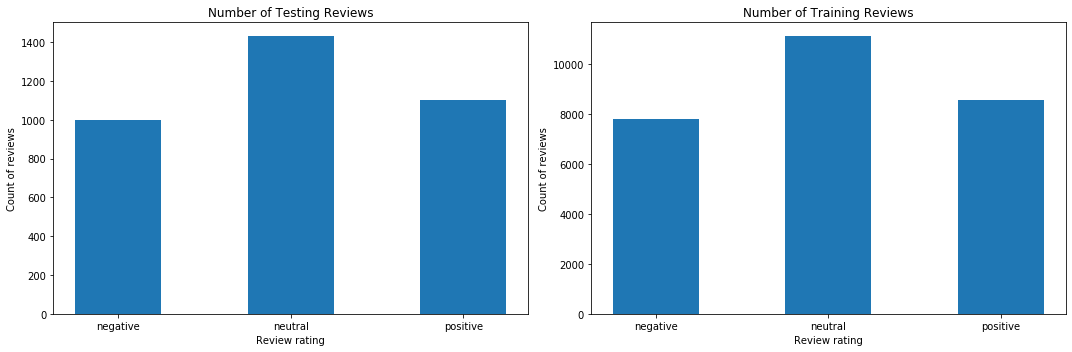

In [7]:
fig, ax = plt.subplots(1,2,figsize = (15,5))

test_values, test_counts = np.unique(test['sentiment'], return_counts = True)
ax[0].bar(test_values, test_counts, width = 0.5)
ax[0].set_xlabel('Review rating')
ax[0].set_ylabel('Count of reviews')
ax[0].set_title('Number of Testing Reviews')


train_values, train_counts = np.unique(train['sentiment'], return_counts = True)
ax[1].bar(train_values, train_counts, width = 0.5)
ax[1].set_xlabel('Review rating')
ax[1].set_ylabel('Count of reviews')
ax[1].set_title('Number of Training Reviews')

plt.tight_layout()

In [8]:
train['sentiment'] = train['sentiment'].map({"negative":0, "neutral":1, 'positive':2})
train.head(5)

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2


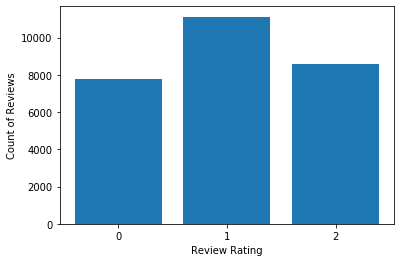

In [9]:
values, counts = np.unique(train['sentiment'], return_counts=True)
plt.figure()
plt.bar(["0","1",'2'], counts)
plt.xlabel('Review Rating')
plt.ylabel('Count of Reviews')
plt.show()

In [10]:
print(counts/np.sum(counts))

[0.28328179 0.40447517 0.31224304]


In [11]:
train

,textID,text,selected_text,sentiment
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0
4,bf7473b12d,haha better drunken tweeting you mean?,better,2
...,...,...,...,...
27480,3dbae74fcd,"I want to go to VP, but no one is willing to c...","I want to go to VP, but no one is willing to c...",1
27481,63147b35cb,"Wah, why are you sad?","Wah, why are you sad?",1
27482,bdb196a09f,playing sudoku while mommy makes me breakfast ...,playing sudoku while mommy makes me breakfast ...,1
27483,18c2a1e98e,see u bye see u! i love the hot30,i love,2


# EDA

In [12]:
train['clean_text'] = train['text']

In [13]:
train.head()

,textID,text,selected_text,sentiment,clean_text
0,a3d0a7d5ad,Spent the entire morning in a meeting w/ a ven...,my boss was not happy w/ them. Lots of fun.,1,Spent the entire morning in a meeting w/ a ven...
1,251b6a6766,Oh! Good idea about putting them on ice cream,Good,2,Oh! Good idea about putting them on ice cream
2,c9e8d1ef1c,says good (or should i say bad?) afternoon! h...,says good (or should i say bad?) afternoon!,1,says good (or should i say bad?) afternoon! h...
3,f14f087215,i dont think you can vote anymore! i tried,i dont think you can vote anymore!,0,i dont think you can vote anymore! i tried
4,bf7473b12d,haha better drunken tweeting you mean?,better,2,haha better drunken tweeting you mean?


#### Word Counts & Characters Counts

In [14]:
train['word_counts'] = train['text'].apply(lambda x : len(str(x).split()))
train['char_counts'] = train['text'].apply(lambda x : len(x))

#### Average Word Length

In [15]:
def avg_length(x):
    words = x.split()
    word_len = 0
    for word in words:
        word_len = word_len + len(word)
    return word_len/len(words)

In [16]:
train['avg_counts'] = train['text'].apply(lambda x : avg_length(x))

#### Count #Hash Tags and @Mentions 

In [17]:
train['hashtags'] = train['text'].apply(lambda x: [w for w in x.split() if w.startswith('#')])
train['mentions'] = train['text'].apply(lambda x: [w for w in x.split() if w.startswith('@')])
train['hashtags_counts'] = train['hashtags'].apply(lambda x: len(x))
train['mentions_counts'] = train['mentions'].apply(lambda x: len(x))

#### Count and Remove URL

In [18]:
train['url'] = train['text'].apply(lambda x: re.findall(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', x))
train['url_counts'] = train['url'].apply(lambda x: len(x))
train['clean_text'] = train['clean_text'].apply(lambda x: re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', "", x))

#### Remove Accented Characters

In [19]:
def accent_char(x):
    x = unicodedata.normalize('NFKD',x).encode('ascii','ignore').decode('utf-8','ignore')
    return x

In [20]:
train['clean_text'] = train['clean_text'].apply( lambda x: accent_char(x))

#### Convert to Lower Case

In [21]:
train['clean_text'] = train['clean_text'].apply( lambda x: x.lower())

#### Remove Punctuation , Numbers & Multiple Spaces

In [22]:
train['clean_text'] = train['clean_text'].apply( lambda x: re.sub('[%s]'%re.escape(string.punctuation),'',x))
train['clean_text'] = train['clean_text'].apply( lambda x: re.sub(r'\d', '', x))
train['clean_text'] = train['clean_text'].apply( lambda x: " ".join(x.split()))

#### Lemmatization

In [23]:
def lemmatization(x):
    texts = []
    doc = nlp(x)
    
    for token in doc:
        lemma = str(token.lemma_)
        if lemma == '-PRON-':
            lemma = token.text
        texts.append(lemma)
    return(" ".join(texts))

In [24]:
train['clean_text'] = train['clean_text'].apply( lambda x: lemmatization(x))

#### Remove Stop Words & Character less than 1

In [25]:
train['clean_text'] = train['clean_text'].apply( lambda x: " ".join([w for w in x.split() if w not in stop_words]))
train['clean_text'] = train['clean_text'].apply(lambda x: " ".join([w for w in x.split() if len(w)>1]))